In [1]:
from model.vit import ViT
from data.dataset import Im2LatexDataset
from transformers import PreTrainedTokenizerFast
from tqdm.auto import tqdm
import warnings
from utils.inkml2img import convert_dir
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
import torch
import sys
import os

sys.path.append("../")

warnings.filterwarnings("ignore")

/Users/dylanh/miniconda3/envs/pytorch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
img_dims = [224, 640]
data = Im2LatexDataset(path_to_data="../data/",
                       tokenizer="../data/tokenizer.json", img_dims=img_dims)
imgs, labels = next(iter(data.train))
imgs.shape

torch.Size([32, 1, 224, 640])

In [3]:

model = ViT(img_dims, 16, n_embd=512)
model(imgs).shape

torch.Size([32, 561, 512])

In [4]:
device = torch.device("cpu")

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("gpu")

device

False

In [9]:
PATH_TO_DATA = "../data/"
PATH_TO_HANDWRITTEN = PATH_TO_DATA + "handwritten/"
# train_handwritten_df = convert_dir(PATH_TO_HANDWRITTEN + 'train', PATH_TO_HANDWRITTEN + "train")
# train_handwritten_df.to_csv(PATH_TO_DATA + 'train_handwritten.csv', index=False)
# val_handwritten_df = convert_dir(PATH_TO_HANDWRITTEN + 'test', PATH_TO_HANDWRITTEN + "test")
# val_handwritten_df.to_csv(PATH_TO_DATA + 'val_handwritten.csv', index=False)

train_handwritten_df = pd.read_csv(PATH_TO_DATA + "train_handwritten.csv")
val_handwritten_df = pd.read_csv(PATH_TO_DATA + "val_handwritten.csv")
val_handwritten_df

,formula,image
0,$r_2 - r_1 = R$,../data/handwritten/test/126_em_481.png
1,$G_u = 2 M_{u v} M_v$,../data/handwritten/test/125_em_428.png
2,$p_A = u + c [L + \frac{1}{3}(a-b)]$,../data/handwritten/test/120_em_293.png
3,$M N = N M$,../data/handwritten/test/123_em_362.png
4,$\mu_n = E[X^n]$,../data/handwritten/test/105_em_71.png
...,...,...
666,$S^{4m+1}$,../data/handwritten/test/105_em_80.png
667,$ \phi ^ {3} + 3 \phi ^ {2} + 18 \phi + 5 + 12 $,../data/handwritten/test/rit_42190_2.png
668,"$a_2 = \frac{P[x_0, x_1] - P[x_1, x_2]}{x0 - x...",../data/handwritten/test/104_em_56.png
669,$\frac{P}{640}$,../data/handwritten/test/121_em_318.png


In [10]:
def fix_path(path):
    return PATH_TO_DATA + "images/" + path


train_df = pd.read_csv(PATH_TO_DATA + "im2latex_train.csv")
val_df = pd.read_csv(PATH_TO_DATA + "im2latex_validate.csv")
test_df = pd.read_csv(PATH_TO_DATA + "im2latex_test.csv")


dataframes = [train_df, val_df, test_df]

for df in dataframes:
    df["image"] = df["image"].map(lambda x: fix_path(x))

print(f"train len before {len(train_df)}")

train_df = pd.concat([train_df, train_handwritten_df])
val_df = pd.concat([val_df, val_handwritten_df])

print(f"train length after {len(train_df)}")

train_df

train len before 75275
train length after 84111


,formula,image
0,\widetilde \gamma _ { \mathrm { h o p f } } \s...,../data/images/66667cee5b.png
1,"( { \cal L } _ { a } g ) _ { i j } = 0 , \ \ \...",../data/images/1cbb05a562.png
2,S _ { s t a t } = 2 \pi \sqrt { N _ { 5 } ^ { ...,../data/images/ed164cc822.png
3,\hat { N } _ { 3 } = \sum \sp f _ { j = 1 } a ...,../data/images/e265f9dc6b.png
4,"\, ^ { * } d \, ^ { * } H = \kappa \, ^ { * } ...",../data/images/242a58bc3a.png
...,...,...
8831,\frac { x_1 } { \frac { x_2 } { \frac { x_3 }...,../data/handwritten/train/200923-1556-78.png
8832,$y = \frac{x\prime\sin\theta+y\prime\sin(w\pri...,../data/handwritten/train/92_edwin.png
8833,$(103 / (18 + 134)) + 109 \leq 110$,../data/handwritten/train/formulaire014-equati...
8834,\sin^{2} \theta + \cos^{2} \theta = 1,../data/handwritten/train/TrainData1_0_sub_9.png


In [11]:
def get_train_equations():
    train_equations = train_df["formula"]
    with open("../data/train_equations.txt", "w") as f:
        for value in train_equations:
            f.write(str(value) + "\n")


# get_train_equations()

In [12]:
import os


def generate_tokenizer(equations, output, vocab_size):
    from tokenizers import Tokenizer, pre_tokenizers
    from tokenizers.models import BPE
    from tokenizers.trainers import BpeTrainer

    tokenizer = Tokenizer(BPE())
    tokenizer.pre_tokenizer = pre_tokenizers.ByteLevel(add_prefix_space=False)
    trainer = BpeTrainer(
        special_tokens=["[PAD]", "[BOS]", "[EOS]"],
        vocab_size=vocab_size,
        show_progress=True,
    )
    tokenizer.train([equations], trainer)
    tokenizer.save(path=output, pretty=False)


# generate_tokenizer('../data/train_equations.txt' ,'../data/tokenizer.json', 8000)
tokenizer = PreTrainedTokenizerFast(tokenizer_file="../data/tokenizer.json")

In [13]:
tokenizer(["boobs"])

{'input_ids': [[451, 79, 66, 83]], 'token_type_ids': [[0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1]]}

In [26]:
class ImagesDataset(Dataset):
    def __init__(self, image_paths, formulas, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        self.formulas = formulas

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths.iloc[index]
        image = Image.open(image_path)
        formula = self.formulas.iloc[index]

        if self.transform:
            image = self.transform(image)

        return image, formula


transform = transforms.Compose(
    [
        transforms.Resize((224, 600)),  # Resize to a specific size
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),  # Convert to tensor
    ]
)

In [27]:
# HYPERPARAMETERS
# -------------------------------------------------
BATCH_SIZE = 32
# -------------------------------------------------

train_dataset = ImagesDataset(
    train_df["image"], train_df["formula"], transform=transform
)
val_dataset = ImagesDataset(
    val_df["image"], val_df["formula"], transform=transform)
test_dataset = ImagesDataset(
    test_df["image"], test_df["formula"], transform=transform)

train_dataloader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False)

'{ \\cal L } _ { \\mathrm { Z l o o p } } ( \\Phi , g , \\theta , W _ { \\mu } , B _ { \\mu } ) \\equiv { \\cal L } _ { \\mathrm { U ( 1 ) } } ( \\rho , \\frac { g } { 2 \\operatorname { c o s } \\theta _ { W } } , \\frac { \\theta } { 2 } , Z _ { \\mu } ) .'

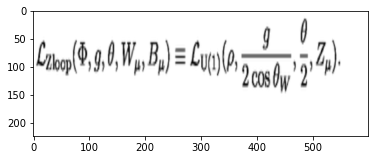

In [28]:
im, label = next(iter(train_dataloader))

plt.imshow(im[0][0], cmap="gray")
label[0]

In [124]:
# transformer block with skip connections and layernorm
class TransformerBlock(nn.Module):
    def __init__(self, n_embd, num_heads, dropout=0.20):
        super().__init__()
        self.embed_dim = n_embd
        self.num_heads = num_heads
        self.dropout = dropout

        self.ln_1 = torch.nn.LayerNorm(n_embd)
        self.attention = SelfAttention(n_embd, num_heads, dropout)
        self.ln_2 = torch.nn.LayerNorm(n_embd)
        self.head = nn.Linear(n_embd, n_embd, bias=False)

    def forward(self, x):
        x = x + self.attention(self.ln_1(x))
        x = x + self.head(self.ln_2(x))
        return x


class PatchEmbeddings(nn.Module):
    def __init__(self, img_size, patch_size, channels=1, embed_dim=512):
        """
        img size: image shape
        """
        super().__init__()
        h, w = img_size
        assert (
            w % patch_size == 0 and h % patch_size == 0
        ), "image not divisable by patch size"
        self.patch_size = patch_size
        self.n_patches = (h // patch_size) * (w // patch_size)

        self.projection = nn.Conv2d(
            channels,
            embed_dim,
            kernel_size=patch_size,
            stride=patch_size,
        )

    def forward(self, x):
        """
        x: batch of images (B, H, W)
        return: (B, num_patches, num_embeddings)
        """
        x = self.projection(x)  # (B, n_embd, n_patches / 2, n_patches / 2)
        x = x.flatten(-2)  # (B, n_embd, n_patches)
        x = x.transpose(-2, -1)  # (B, n_patches, n_embd)
        return x


class SelfAttention(nn.Module):
    def __init__(
        self, n_embd, n_heads=8, bias=False, attn_dropout=0.20, proj_dropout=0.20
    ):
        super().__init__()
        assert n_embd % n_heads == 0, "n_embd not divisible by num heads"
        self.n_heads = n_heads
        self.n_embd = n_embd
        self.head_dim = n_embd // n_heads
        self.dk = self.head_dim**-0.5  # sqrt dk for scaling

        self.kqv = nn.Linear(n_embd, n_embd * 3, bias=bias)
        self.projection = nn.Linear(n_embd, n_embd, bias=bias)
        self.attn_dropout = nn.Dropout(attn_dropout)
        self.proj_dropout = nn.Dropout(proj_dropout)

    def forward(self, x):
        """
        x: (B, T, n_embd)
        returns: (B, T, n_embd)
        """

        B, T, C, = x.shape  # batch size, num tokens, n_embd
        assert C == self.n_embd, "input size does not equal n_embd"

        kqv = self.kqv(x)  # (B, T, n_embd*3)
        kqv = kqv.reshape(B, T, 3, self.n_heads, self.head_dim)
        kqv = kqv.permute(2, 0, 3, 1, 4)  # (3, B, n_heads, T, head_dim)
        k, q, v = kqv  # (B, n_heads, T, head_dim)

        attention = (
            q @ k.transpose(-1, -2)
        ) * self.dk  # (B, n_heads, T, head_dim) @ (B, n_heads, head_dim, T) -> (B, n_heads, T, T)
        attention = attention.softmax(dim=-1)  # (B, n_heads, T, T)
        attention = self.attn_dropout(attention)
        aggregated_attention = (
            attention @ v
        )  # (B, n_heads, T, T) @ (B, n_heads, T, head_dim) -> (B, n_heads, T, head_dim)
        print(aggregated_attention.shape)
        x = aggregated_attention.transpose(1, 2)  # (B, T, n_heads, C)
        x = x.flatten(2)  # (B, T, C)
        x = self.projection(x)  # (B, T, C)
        x = self.proj_dropout(x)
        return x


x = torch.ones(1, 1, 64, 64)
patch = PatchEmbeddings([64, 64], 16)
# attention = SelfAttention(512)
x = patch(x)
# att = attention(x)
block = TransformerBlock(512, 8)
block(x)

torch.Size([1, 8, 16, 16]) torch.Size([1, 8, 16, 64])
torch.Size([1, 8, 16, 64])


tensor([[[-0.9330, -2.6161,  0.8858,  ..., -0.1316,  0.4870,  0.0277],
         [-0.8579, -2.5277,  0.6462,  ...,  0.2611,  0.3984, -0.5303],
         [-0.7481, -2.6428,  0.7518,  ...,  0.2218,  0.3767, -0.0528],
         ...,
         [-0.6207, -2.6100,  0.2552,  ...,  0.2584,  0.2760, -0.5433],
         [-0.6320, -2.6775,  0.7743,  ..., -0.0517,  0.5550,  0.1714],
         [-0.4915, -2.5473,  0.6142,  ...,  0.2151,  0.7661, -0.4765]]],
       grad_fn=<AddBackward0>)